In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter
import matplotlib as mpl

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:0


In [ ]:
# def true_2D_1(xt): #True function for 2D_1 Klein Gordon Equation x \in [-50,50] , t \in [0,10]
#     y = xt[:,0]*np.cos(xt[:,1])
#     return y.reshape(-1,1)    

In [2]:
#Material Properties This link - https://www.mathworks.com/help/pde/ug/nonlinear-heat-transfer-in-a-thin-plate.html#heatTransferThinPlateExample-1
k = 400
rho = 8960
cp = 386
t_z = 0.01
stef_bolt = 5.670373e-8
hc = 1
Ta = 300
emiss = 0.5


In [3]:
label = "Navier_stan"

x = np.linspace(0,1,100).reshape(-1,1)
y = np.linspace(0,1,100).reshape(-1,1)
t = np.linspace(0,1,100).reshape(-1,1) #t is actually from 0 to 5000, let us scale it to 0 to 1

X,Y,T = np.meshgrid(x,y,t)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
T = T.flatten('F').reshape(-1,1)
  
xyt = np.hstack((X,Y,T))

initial_pts = np.logical_and(T==0,Y!=0).reshape(-1,)

DBC_pts = (Y == 0).reshape(-1,)


NBC_pts_x0 = (X == 0).reshape(-1,)
NBC_pts_x1 = (X == 1).reshape(-1,)

NBC_pts_y0 = (Y == 0).reshape(-1,)
NBC_pts_y1 = (Y == 1).reshape(-1,)

xyt_initial = xyt[initial_pts,:]
xyt_DBC = xyt[DBC_pts,:]

xyt_NBC_x0 = xyt[NBC_pts_x0,:]
xyt_NBC_x1 = xyt[NBC_pts_x1,:]

#xyt_NBC_y0 = xyt[NBC_pts_y0,:]
xyt_NBC_y1 = xyt[NBC_pts_y1,:]

u_initial = 300*np.ones((np.shape(xyt_initial)[0],1))
u_DBC = 1000*np.ones((np.shape(xyt_DBC)[0],1))

xyt_I_DBC = np.vstack((xyt_initial,xyt_DBC))
#xyt_NBC = np.vstack((xyt_NBC_1,xyt_NBC_2,xyt_NBC_3,xyt_NBC_4))
xyt_NBC_x = np.vstack((xyt_NBC_x0,xyt_NBC_x1))
#xyt_NBC_y = np.vstack((xyt_NBC_y0,xyt_NBC_y1))
xyt_NBC_y = np.vstack((xyt_NBC_y1))

u_I_DBC = np.vstack((u_initial,u_DBC))

xyt_test_tensor = torch.from_numpy(xyt).float().to(device)

lb_xyt = xyt[0]
ub_xyt = xyt[-1]

In [4]:
def trainingdata(N_D,N_N,N_f,seed):
    '''Boundary Conditions''' 
    
    np.random.seed(seed)
    
    #choose random N_u points for training
    idx = np.random.choice(xyt_I_DBC.shape[0], N_D, replace=False) 
    xyt_D = xyt_I_DBC[idx,:] #choose indices from  set 'idx' (x,t)
    u_D = u_I_DBC[idx].reshape(-1,1)      #choose corresponding u

    idx = np.random.choice(xyt_NBC_x.shape[0], N_D, replace=False) 
    xyt_Nx = xyt_NBC_x[idx,:] #choose indices from  set 'idx' (x,t)

    idx = np.random.choice(xyt_NBC_y.shape[0], N_D, replace=False) 
    xyt_Ny = xyt_NBC_y[idx,:] #choose indices from  set 'idx' (x,t)

    '''Collocation Points'''
    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x01 = np.array([[0.0,1.0],[0.0,1.0],[0.0,1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    samples = sampling(N_f)
    
    xyt_coll = lb_xyt + (ub_xyt - lb_xyt)*samples
    xyt_coll = np.vstack((xyt_coll, xyt_D,xyt_Nx,xyt_Ny)) # append training points to collocation points 

    return xyt_coll, xyt_D, u_D, xyt_Nx,xyt_Ny

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        
        self.beta = Parameter(torch.ones((50,len(layers)-2)))
        self.beta.requiresGrad = True
        
        self.train_loss = []
        self.test_loss = []
        
        self.beta_val = []
        
        self.n = torch.tensor(1.0)
            
    'foward pass'
    def forward(self,xyt):
        if torch.is_tensor(xyt) != True:         
            xyt = torch.from_numpy(xyt)                
        
        ubxyt = torch.from_numpy(ub_xyt).float().to(device)
        lbxyt = torch.from_numpy(lb_xyt).float().to(device)
    
                      
        #preprocessing input 
        xyt = (xyt - lbxyt)/(ubxyt - lbxyt)
        
        #convert to float
        a = xyt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            z1 = self.activation(z) 
            a = z1 + self.beta[:,i]*z*z1
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_D(self,xyt_D,u_D):
                
        loss_bc = self.loss_function(self.forward(xyt_D), u_D)
                
        return loss_bc
    
    def loss_N(self,xyt_Nx,xyt_Ny,N_hat):
        
        g1 = xyt_Nx.clone()             
        g1.requires_grad = True
        u1 = self.forward(g1)
        
        u1_x_y_t = autograd.grad(u1,g1,torch.ones([xyt_Nx.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        du1_dx = u1_x_y_t[:,[0]]
        
        g2 = xyt_Ny.clone()             
        g2.requires_grad = True
        u2 = self.forward(g2)
        
        u2_x_y_t = autograd.grad(u2,g2,torch.ones([xyt_Ny.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        du2_dy = u2_x_y_t[:,[1]]
               
        loss_N1 = self.loss_function(du1_dx,N_hat)
        loss_N2 = self.loss_function(du2_dy,N_hat)
        
        #return loss_N1+loss_N2       
        return loss_N1 + loss_N2
    
    def loss_PDE(self, xyt_coll, f_hat):
        
        g = xyt_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_y_t = autograd.grad(u,g,torch.ones([xyt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_yy_tt = autograd.grad(u_x_y_t,g,torch.ones(xyt_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        du_dt = u_x_y_t[:,[2]]
        
        d2u_dx2 = u_xx_yy_tt[:,[0]]
        d2u_dy2 = u_xx_yy_tt[:,[1]]    
        

        f = rho*cp*t_z*du_dt/3000 - k*t_z*(d2u_dx2+d2u_dy2) + 2*hc*(u-Ta) + 2*emiss*stef_bolt*(torch.pow(u,4)-Ta**4) 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xyt_D,u_D,xyt_Nx,xyt_Ny,N_hat,xyt_coll,f_hat):

        loss_D = self.loss_D(xyt_D,u_D)
        loss_N = self.loss_N(xyt_Nx,xyt_Ny,N_hat)
        loss_f = self.loss_PDE(xyt_coll,f_hat)
        
        loss_val = loss_D + loss_N + loss_f
        
        #print(self.iter,"loss_D:",loss_D.cpu().detach().numpy(),"loss_N:",loss_N.cpu().detach().numpy(),"loss_f:",loss_f.cpu().detach().numpy())
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        optimizer.zero_grad()
        
        loss = self.loss(xyt_D,u_D,xyt_Nx,xyt_Ny,N_hat,xyt_coll,f_hat)
        self.train_loss.append(loss.cpu().detach().numpy())
        
        u_pred = self.test(xyt_test_tensor)
        #self.test_loss.append(np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))) #Commented because no true values yet
        self.beta_val.append(self.beta.cpu().detach().numpy())
        
        #print(self.iter,"Train Loss",self.train_loss[-1],"Test Loss",self.test_loss[-1])
        print(self.iter,"Train Loss",self.train_loss[-1])
        
        loss.backward()
        self.iter += 1
  

        return loss        
    'test neural network'
    def test(self,xyt_test_tensor):
        u_pred = self.forward(xyt_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

In [6]:
max_reps = 1

train_loss_full = []
test_loss_full = []
beta_full = []
elapsed_time= np.zeros((max_reps,1))

#for reps in range(max_reps):
for reps in range(8,9):
    print(reps)
    
    torch.manual_seed(reps*36)
    N_D = 5000 #Total number of data points for 'y'
    N_N = 3500
    N_f = 10000 #Total number of collocation points 
    
    xyt_coll_np_array, xyt_D_np_array, u_D_np_array,xyt_Nx_np_array,xyt_Ny_np_array = trainingdata(N_D,N_N,N_f,(reps)*22)
        
    xyt_coll = torch.from_numpy(xyt_coll_np_array).float().to(device)
    xyt_D = torch.from_numpy(xyt_D_np_array).float().to(device)
    u_D = torch.from_numpy(u_D_np_array).float().to(device)
    xyt_Nx = torch.from_numpy(xyt_Nx_np_array).float().to(device)
    xyt_Ny = torch.from_numpy(xyt_Ny_np_array).float().to(device)
        
    N_hat = torch.zeros(xyt_Nx.shape[0],1).to(device)    
    f_hat = torch.zeros(xyt_coll.shape[0],1).to(device)

    layers = np.array([3,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers
    #layers = np.array([3,100,100,100,100,100,100,100,1])

    PINN = Sequentialmodel(layers)
   
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())
    
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=1, 
                              max_iter = 10000, 
                              max_eval = None, 
                              tolerance_grad = -1, 
                              tolerance_change = -1, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')



    start_time = time.time()
        
    optimizer.step(PINN.closure)
    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(PINN.train_loss)
    test_loss_full.append(PINN.test_loss)
    elapsed_time[reps] = time.time() - start_time
    beta_full.append(PINN.beta_val)


    print('Training time: %.2f' % (elapsed_time[reps]))
    
mdic = {"train_loss": train_loss_full,"test_loss": test_loss_full,"Time": elapsed_time, "beta": beta_full, "label": label}
savemat(label+'.mat', mdic)

8
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0 Train Loss 1717479.5
1 Train Loss 1706014.8
2 Train Loss 1637955.5
3 Train Loss 1571750.8
4 Train Loss 1743481.8
5 Train Loss 1516922.5
6 Train Loss 1455199.5
7 Train Loss 1393477.5
8 Train Loss 1281591.1
9 Train Loss 1027741.4
10 Train Loss 3134900.5
11 Train Loss 1000831.6
12 Train Loss 965815.5

311 Train Loss 50261.906
312 Train Loss 50137.594
313 Train Loss 50027.0
314 Train Loss 49952.7
315 Train Loss 49905.3
316 Train Loss 49879.242
317 Train Loss 49844.867
318 Train Loss 49821.2
319 Train Loss 49801.457
320 Train Loss 49754.13
321 Train Loss 49656.004
322 Train Loss 49506.402
323 Train Loss 49270.39
324 Train Loss 48947.65
325 Train Loss 48582.043
326 Train Loss 48392.414
327 Train Loss 48233.89
328 Train Loss 48141.586
329 Train Loss 48030.297
330 Train Loss 47925.69
331 Train Loss 47835.2
332 Train Loss 47710.656
333 Train Loss 47632.58
334 Train Loss 47593.836
335 Train Loss 47561.785
336 Train Loss 47535.59
337 Train Loss 47517.75
338 Train Loss 47484.246
339 Train Loss 47452.734
340 Train Loss 47421.625
341 Train Loss 47391.68
342 Train Loss 47344.105
343 Train Loss 47285.508
344 Train Loss 47285.793
345 Train Loss 47248.164
346 Train Loss 47176.812
347 Train Loss 47102.62
348 Train Loss 46976.08
349 Train Loss 46848.4
350 Train Loss 47632.125
351 Train Loss 46787.07

645 Train Loss 28354.541
646 Train Loss 28369.254
647 Train Loss 28334.447
648 Train Loss 28280.81
649 Train Loss 28193.852
650 Train Loss 28099.314
651 Train Loss 28049.895
652 Train Loss 28001.643
653 Train Loss 27998.012
654 Train Loss 27974.832
655 Train Loss 27977.879
656 Train Loss 27944.117
657 Train Loss 27893.775
658 Train Loss 27847.543
659 Train Loss 27800.158
660 Train Loss 28344.17
661 Train Loss 27782.8
662 Train Loss 27715.32
663 Train Loss 27651.18
664 Train Loss 27642.14
665 Train Loss 27592.898
666 Train Loss 27562.64
667 Train Loss 27508.918
668 Train Loss 27457.705
669 Train Loss 27425.3
670 Train Loss 27378.578
671 Train Loss 27329.514
672 Train Loss 27287.674
673 Train Loss 27260.254
674 Train Loss 27237.465
675 Train Loss 27222.354
676 Train Loss 27211.988
677 Train Loss 27202.979
678 Train Loss 27191.812
679 Train Loss 27178.564
680 Train Loss 27164.877
681 Train Loss 27149.012
682 Train Loss 27140.742
683 Train Loss 27130.213
684 Train Loss 27116.562
685 Train 

977 Train Loss 20460.51
978 Train Loss 20724.732
979 Train Loss 20446.814
980 Train Loss 20426.95
981 Train Loss 20574.56
982 Train Loss 20416.86
983 Train Loss 20408.697
984 Train Loss 20399.07
985 Train Loss 20388.418
986 Train Loss 20361.713
987 Train Loss 20399.525
988 Train Loss 20344.572
989 Train Loss 20328.111
990 Train Loss 20297.96
991 Train Loss 20285.623
992 Train Loss 20265.955
993 Train Loss 20248.36
994 Train Loss 20234.703
995 Train Loss 20223.426
996 Train Loss 20211.945
997 Train Loss 20203.867
998 Train Loss 20192.434
999 Train Loss 20184.71
1000 Train Loss 20172.62
1001 Train Loss 20159.365
1002 Train Loss 20138.672
1003 Train Loss 20122.48
1004 Train Loss 20090.197
1005 Train Loss 20065.223
1006 Train Loss 20061.967
1007 Train Loss 20037.525
1008 Train Loss 20016.746
1009 Train Loss 19996.986
1010 Train Loss 19980.512
1011 Train Loss 19961.543
1012 Train Loss 19972.564
1013 Train Loss 19943.512
1014 Train Loss 19924.273
1015 Train Loss 19903.064
1016 Train Loss 198

1297 Train Loss 18027.223
1298 Train Loss 18027.084
1299 Train Loss 18024.514
1300 Train Loss 18021.934
1301 Train Loss 18018.74
1302 Train Loss 18015.621
1303 Train Loss 18011.371
1304 Train Loss 18007.424
1305 Train Loss 18003.547
1306 Train Loss 17999.016
1307 Train Loss 17997.932
1308 Train Loss 17996.137
1309 Train Loss 17992.643
1310 Train Loss 17996.738
1311 Train Loss 17991.506
1312 Train Loss 17991.025
1313 Train Loss 17987.398
1314 Train Loss 17984.832
1315 Train Loss 17980.883
1316 Train Loss 17977.086
1317 Train Loss 17973.201
1318 Train Loss 17968.277
1319 Train Loss 17959.701
1320 Train Loss 17955.459
1321 Train Loss 17959.977
1322 Train Loss 17951.719
1323 Train Loss 17948.303
1324 Train Loss 17945.207
1325 Train Loss 17940.78
1326 Train Loss 17933.918
1327 Train Loss 17928.822
1328 Train Loss 17925.777
1329 Train Loss 17937.125
1330 Train Loss 17923.383
1331 Train Loss 17921.195
1332 Train Loss 17916.432
1333 Train Loss 17911.516
1334 Train Loss 17908.297
1335 Train Los

1615 Train Loss 17198.543
1616 Train Loss 17193.773
1617 Train Loss 17192.203
1618 Train Loss 17190.414
1619 Train Loss 17185.963
1620 Train Loss 17185.83
1621 Train Loss 17183.15
1622 Train Loss 17181.883
1623 Train Loss 17180.648
1624 Train Loss 17179.572
1625 Train Loss 17178.219
1626 Train Loss 17177.154
1627 Train Loss 17175.492
1628 Train Loss 17174.32
1629 Train Loss 17172.305
1630 Train Loss 17176.246
1631 Train Loss 17171.652
1632 Train Loss 17175.36
1633 Train Loss 17167.979
1634 Train Loss 17163.564
1635 Train Loss 17171.447
1636 Train Loss 17161.182
1637 Train Loss 17158.979
1638 Train Loss 17154.707
1639 Train Loss 17151.861
1640 Train Loss 17146.746
1641 Train Loss 17145.312
1642 Train Loss 17142.814
1643 Train Loss 17140.31
1644 Train Loss 17135.521
1645 Train Loss 17125.855
1646 Train Loss 17131.072
1647 Train Loss 17123.934
1648 Train Loss 17124.998
1649 Train Loss 17121.104
1650 Train Loss 17121.84
1651 Train Loss 17119.459
1652 Train Loss 17117.582
1653 Train Loss 17

1933 Train Loss 16358.587
1934 Train Loss 16358.17
1935 Train Loss 16357.646
1936 Train Loss 16356.972
1937 Train Loss 16356.117
1938 Train Loss 16355.441
1939 Train Loss 16354.887
1940 Train Loss 16354.01
1941 Train Loss 16353.288
1942 Train Loss 16352.742
1943 Train Loss 16352.355
1944 Train Loss 16351.909
1945 Train Loss 16351.5
1946 Train Loss 16351.039
1947 Train Loss 16350.508
1948 Train Loss 16349.744
1949 Train Loss 16348.582
1950 Train Loss 16576.064
1951 Train Loss 16348.271
1952 Train Loss 16346.737
1953 Train Loss 16343.262
1954 Train Loss 16342.315
1955 Train Loss 16339.051
1956 Train Loss 16333.616
1957 Train Loss 16330.4
1958 Train Loss 16326.525
1959 Train Loss 16326.587
1960 Train Loss 16324.957
1961 Train Loss 16321.63
1962 Train Loss 16319.108
1963 Train Loss 16315.946
1964 Train Loss 16311.654
1965 Train Loss 16306.537
1966 Train Loss 16302.167
1967 Train Loss 16294.61
1968 Train Loss 16287.522
1969 Train Loss 16284.233
1970 Train Loss 16278.777
1971 Train Loss 1630

2251 Train Loss 15712.947
2252 Train Loss 15711.782
2253 Train Loss 15708.928
2254 Train Loss 15706.007
2255 Train Loss 15703.083
2256 Train Loss 15702.247
2257 Train Loss 15701.389
2258 Train Loss 15700.945
2259 Train Loss 15700.262
2260 Train Loss 15699.524
2261 Train Loss 15704.51
2262 Train Loss 15699.133
2263 Train Loss 15698.017
2264 Train Loss 15697.159
2265 Train Loss 15696.432
2266 Train Loss 15695.472
2267 Train Loss 15694.448
2268 Train Loss 15693.436
2269 Train Loss 15692.335
2270 Train Loss 15691.253
2271 Train Loss 15689.562
2272 Train Loss 15688.138
2273 Train Loss 15686.639
2274 Train Loss 15685.927
2275 Train Loss 15683.172
2276 Train Loss 15681.359
2277 Train Loss 15679.163
2278 Train Loss 15678.819
2279 Train Loss 15677.907
2280 Train Loss 15678.043
2281 Train Loss 15676.564
2282 Train Loss 15675.1
2283 Train Loss 15673.437
2284 Train Loss 15671.872
2285 Train Loss 15696.5625
2286 Train Loss 15671.286
2287 Train Loss 15669.705
2288 Train Loss 15666.765
2289 Train Los

2567 Train Loss 15045.379
2568 Train Loss 15034.458
2569 Train Loss 15036.285
2570 Train Loss 15030.509
2571 Train Loss 15045.504
2572 Train Loss 15027.337
2573 Train Loss 15026.174
2574 Train Loss 15021.339
2575 Train Loss 15021.142
2576 Train Loss 15020.025
2577 Train Loss 15018.745
2578 Train Loss 15016.603
2579 Train Loss 15014.169
2580 Train Loss 15011.023
2581 Train Loss 15009.492
2582 Train Loss 15008.068
2583 Train Loss 15007.168
2584 Train Loss 15003.825
2585 Train Loss 14999.952
2586 Train Loss 14996.514
2587 Train Loss 14992.064
2588 Train Loss 14990.082
2589 Train Loss 14987.711
2590 Train Loss 14984.247
2591 Train Loss 14981.607
2592 Train Loss 14978.651
2593 Train Loss 14976.351
2594 Train Loss 14975.977
2595 Train Loss 14974.292
2596 Train Loss 14970.566
2597 Train Loss 14969.284
2598 Train Loss 14965.634
2599 Train Loss 14957.733
2600 Train Loss 14948.324
2601 Train Loss 14948.226
2602 Train Loss 14944.226
2603 Train Loss 15321.566
2604 Train Loss 14939.012
2605 Train L

2883 Train Loss 14112.594
2884 Train Loss 14105.54
2885 Train Loss 14130.345
2886 Train Loss 14100.608
2887 Train Loss 14111.731
2888 Train Loss 14095.603
2889 Train Loss 14105.834
2890 Train Loss 14092.294
2891 Train Loss 14089.774
2892 Train Loss 14088.604
2893 Train Loss 14080.831
2894 Train Loss 14077.253
2895 Train Loss 14071.848
2896 Train Loss 14065.42
2897 Train Loss 14062.719
2898 Train Loss 14059.733
2899 Train Loss 14058.139
2900 Train Loss 14056.401
2901 Train Loss 14055.071
2902 Train Loss 14053.464
2903 Train Loss 14051.121
2904 Train Loss 14050.037
2905 Train Loss 14048.306
2906 Train Loss 14046.421
2907 Train Loss 14045.105
2908 Train Loss 14047.045
2909 Train Loss 14043.462
2910 Train Loss 14041.381
2911 Train Loss 14039.905
2912 Train Loss 14038.288
2913 Train Loss 14036.354
2914 Train Loss 14035.244
2915 Train Loss 14031.802
2916 Train Loss 14028.563
2917 Train Loss 14025.176
2918 Train Loss 14022.882
2919 Train Loss 14021.702
2920 Train Loss 14017.987
2921 Train Los

3201 Train Loss 13193.353
3202 Train Loss 13207.271
3203 Train Loss 13193.106
3204 Train Loss 13192.443
3205 Train Loss 13191.791
3206 Train Loss 13191.181
3207 Train Loss 13193.519
3208 Train Loss 13190.918
3209 Train Loss 13190.23
3210 Train Loss 13189.265
3211 Train Loss 13189.474
3212 Train Loss 13188.897
3213 Train Loss 13188.227
3214 Train Loss 13187.1
3215 Train Loss 13186.074
3216 Train Loss 13185.026
3217 Train Loss 13183.991
3218 Train Loss 13183.053
3219 Train Loss 13182.18
3220 Train Loss 13181.715
3221 Train Loss 13180.982
3222 Train Loss 13179.967
3223 Train Loss 13178.614
3224 Train Loss 13176.833
3225 Train Loss 13174.953
3226 Train Loss 13173.018
3227 Train Loss 13171.188
3228 Train Loss 13167.951
3229 Train Loss 13165.131
3230 Train Loss 13163.245
3231 Train Loss 13159.273
3232 Train Loss 13156.9375
3233 Train Loss 13154.489
3234 Train Loss 13152.625
3235 Train Loss 13150.435
3236 Train Loss 13147.663
3237 Train Loss 13143.226
3238 Train Loss 14125.117
3239 Train Loss

3517 Train Loss 12761.314
3518 Train Loss 12760.523
3519 Train Loss 12759.012
3520 Train Loss 12757.517
3521 Train Loss 12755.636
3522 Train Loss 12754.675
3523 Train Loss 12755.771
3524 Train Loss 12753.898
3525 Train Loss 12754.779
3526 Train Loss 12753.226
3527 Train Loss 12752.722
3528 Train Loss 12752.029
3529 Train Loss 12751.456
3530 Train Loss 12750.681
3531 Train Loss 12748.651
3532 Train Loss 12748.181
3533 Train Loss 12747.971
3534 Train Loss 12747.045
3535 Train Loss 12746.388
3536 Train Loss 12745.057
3537 Train Loss 12744.393
3538 Train Loss 12743.234
3539 Train Loss 12741.575
3540 Train Loss 12796.817
3541 Train Loss 12741.21
3542 Train Loss 12741.434
3543 Train Loss 12740.026
3544 Train Loss 12738.056
3545 Train Loss 12742.462
3546 Train Loss 12736.884
3547 Train Loss 12754.815
3548 Train Loss 12736.284
3549 Train Loss 12736.44
3550 Train Loss 12735.232
3551 Train Loss 12734.082
3552 Train Loss 12732.243
3553 Train Loss 12731.985
3554 Train Loss 12731.449
3555 Train Los

3833 Train Loss 12336.386
3834 Train Loss 12334.457
3835 Train Loss 12332.741
3836 Train Loss 12331.257
3837 Train Loss 12332.611
3838 Train Loss 12330.569
3839 Train Loss 12329.869
3840 Train Loss 12329.085
3841 Train Loss 12328.369
3842 Train Loss 12327.173
3843 Train Loss 12325.989
3844 Train Loss 12324.865
3845 Train Loss 12323.704
3846 Train Loss 12322.708
3847 Train Loss 12321.824
3848 Train Loss 12321.0205
3849 Train Loss 12320.013
3850 Train Loss 12318.724
3851 Train Loss 12317.837
3852 Train Loss 12317.194
3853 Train Loss 12316.552
3854 Train Loss 12316.262
3855 Train Loss 12315.848
3856 Train Loss 12315.348
3857 Train Loss 12314.759
3858 Train Loss 12313.44
3859 Train Loss 12313.359
3860 Train Loss 12312.423
3861 Train Loss 12310.952
3862 Train Loss 12309.434
3863 Train Loss 12307.767
3864 Train Loss 12306.452
3865 Train Loss 12305.2295
3866 Train Loss 12303.624
3867 Train Loss 12302.176
3868 Train Loss 12300.838
3869 Train Loss 12301.839
3870 Train Loss 12299.9375
3871 Train

4149 Train Loss 11901.814
4150 Train Loss 11901.244
4151 Train Loss 11899.487
4152 Train Loss 11898.336
4153 Train Loss 11896.639
4154 Train Loss 11893.586
4155 Train Loss 11897.731
4156 Train Loss 11892.754
4157 Train Loss 11891.027
4158 Train Loss 11889.248
4159 Train Loss 11887.996
4160 Train Loss 11886.96
4161 Train Loss 11887.952
4162 Train Loss 11886.269
4163 Train Loss 11885.1875
4164 Train Loss 11883.761
4165 Train Loss 11881.857
4166 Train Loss 11879.719
4167 Train Loss 11875.644
4168 Train Loss 11870.002
4169 Train Loss 11891.134
4170 Train Loss 11868.102
4171 Train Loss 11869.284
4172 Train Loss 11863.378
4173 Train Loss 11859.815
4174 Train Loss 11855.125
4175 Train Loss 11852.304
4176 Train Loss 11851.07
4177 Train Loss 11846.683
4178 Train Loss 11844.268
4179 Train Loss 11841.573
4180 Train Loss 12028.031
4181 Train Loss 11840.956
4182 Train Loss 11838.987
4183 Train Loss 11837.17
4184 Train Loss 11835.238
4185 Train Loss 11834.114
4186 Train Loss 11833.385
4187 Train Los

4467 Train Loss 11486.374
4468 Train Loss 11486.331
4469 Train Loss 11485.965
4470 Train Loss 11485.083
4471 Train Loss 11484.354
4472 Train Loss 11483.233
4473 Train Loss 11482.434
4474 Train Loss 11562.677
4475 Train Loss 11480.84
4476 Train Loss 11479.43
4477 Train Loss 11483.531
4478 Train Loss 11478.402
4479 Train Loss 11477.227
4480 Train Loss 11476.157
4481 Train Loss 11475.642
4482 Train Loss 11473.551
4483 Train Loss 11472.292
4484 Train Loss 11470.686
4485 Train Loss 11469.8125
4486 Train Loss 11468.06
4487 Train Loss 11466.603
4488 Train Loss 11465.346
4489 Train Loss 11464.56
4490 Train Loss 11463.764
4491 Train Loss 11463.198
4492 Train Loss 11462.459
4493 Train Loss 11461.717
4494 Train Loss 11461.238
4495 Train Loss 11460.4375
4496 Train Loss 11459.982
4497 Train Loss 11459.497
4498 Train Loss 11459.257
4499 Train Loss 11457.798
4500 Train Loss 11456.839
4501 Train Loss 11455.843
4502 Train Loss 11454.906
4503 Train Loss 11454.542
4504 Train Loss 11453.515
4505 Train Los

4783 Train Loss 11166.087
4784 Train Loss 11165.276
4785 Train Loss 11163.991
4786 Train Loss 11163.047
4787 Train Loss 11161.985
4788 Train Loss 11188.453
4789 Train Loss 11161.807
4790 Train Loss 11160.626
4791 Train Loss 11158.808
4792 Train Loss 11158.075
4793 Train Loss 11157.568
4794 Train Loss 11156.721
4795 Train Loss 11155.983
4796 Train Loss 11154.92
4797 Train Loss 11154.284
4798 Train Loss 11153.219
4799 Train Loss 11152.982
4800 Train Loss 11152.599
4801 Train Loss 11152.317
4802 Train Loss 11151.169
4803 Train Loss 11150.479
4804 Train Loss 11149.387
4805 Train Loss 11146.703
4806 Train Loss 11146.196
4807 Train Loss 11145.219
4808 Train Loss 11143.334
4809 Train Loss 11142.315
4810 Train Loss 11141.557
4811 Train Loss 11140.807
4812 Train Loss 11139.86
4813 Train Loss 11139.19
4814 Train Loss 11138.514
4815 Train Loss 11138.216
4816 Train Loss 11137.941
4817 Train Loss 11137.454
4818 Train Loss 11139.478
4819 Train Loss 11137.273
4820 Train Loss 11137.307
4821 Train Loss

5101 Train Loss 10847.015
5102 Train Loss 10829.309
5103 Train Loss 10824.556
5104 Train Loss 10829.594
5105 Train Loss 10821.929
5106 Train Loss 10816.857
5107 Train Loss 10831.119
5108 Train Loss 10814.787
5109 Train Loss 10808.442
5110 Train Loss 10802.892
5111 Train Loss 10798.387
5112 Train Loss 10839.117
5113 Train Loss 10794.821
5114 Train Loss 10789.9
5115 Train Loss 10779.714
5116 Train Loss 10793.884
5117 Train Loss 10775.362
5118 Train Loss 10769.434
5119 Train Loss 10762.2295
5120 Train Loss 10786.053
5121 Train Loss 10759.832
5122 Train Loss 10765.515
5123 Train Loss 10756.346
5124 Train Loss 10752.07
5125 Train Loss 10747.896
5126 Train Loss 10740.761
5127 Train Loss 10748.981
5128 Train Loss 10736.127
5129 Train Loss 10733.887
5130 Train Loss 10727.934
5131 Train Loss 10724.456
5132 Train Loss 10853.552
5133 Train Loss 10723.791
5134 Train Loss 10720.411
5135 Train Loss 10715.191
5136 Train Loss 10717.758
5137 Train Loss 10712.363
5138 Train Loss 10708.301
5139 Train Los

5417 Train Loss 10458.786
5418 Train Loss 10457.977
5419 Train Loss 10462.258
5420 Train Loss 10457.504
5421 Train Loss 10456.415
5422 Train Loss 10455.654
5423 Train Loss 10454.971
5424 Train Loss 10455.763
5425 Train Loss 10454.524
5426 Train Loss 10453.953
5427 Train Loss 10456.826
5428 Train Loss 10453.743
5429 Train Loss 10453.112
5430 Train Loss 10453.5
5431 Train Loss 10452.812
5432 Train Loss 10452.1455
5433 Train Loss 10450.756
5434 Train Loss 10448.654
5435 Train Loss 10451.065
5436 Train Loss 10447.412
5437 Train Loss 10444.936
5438 Train Loss 10444.257
5439 Train Loss 10442.982
5440 Train Loss 10442.193
5441 Train Loss 10441.594
5442 Train Loss 10440.83
5443 Train Loss 10440.097
5444 Train Loss 10439.763
5445 Train Loss 10439.216
5446 Train Loss 10438.639
5447 Train Loss 10438.295
5448 Train Loss 10437.959
5449 Train Loss 10437.66
5450 Train Loss 10437.4
5451 Train Loss 10437.506
5452 Train Loss 10437.227
5453 Train Loss 10436.972
5454 Train Loss 10436.614
5455 Train Loss 1

5735 Train Loss 10202.974
5736 Train Loss 10202.425
5737 Train Loss 10202.211
5738 Train Loss 10203.765
5739 Train Loss 10202.132
5740 Train Loss 10223.307
5741 Train Loss 10201.966
5742 Train Loss 10201.58
5743 Train Loss 10200.971
5744 Train Loss 10200.283
5745 Train Loss 10199.589
5746 Train Loss 10198.961
5747 Train Loss 10198.268
5748 Train Loss 10197.604
5749 Train Loss 10197.086
5750 Train Loss 10196.677
5751 Train Loss 10196.312
5752 Train Loss 10195.904
5753 Train Loss 10195.513
5754 Train Loss 10195.053
5755 Train Loss 10194.4
5756 Train Loss 10193.755
5757 Train Loss 10192.827
5758 Train Loss 10192.237
5759 Train Loss 10191.509
5760 Train Loss 10190.803
5761 Train Loss 10189.999
5762 Train Loss 10189.802
5763 Train Loss 10189.568
5764 Train Loss 10188.862
5765 Train Loss 10188.215
5766 Train Loss 10187.313
5767 Train Loss 10186.164
5768 Train Loss 10185.036
5769 Train Loss 10183.416
5770 Train Loss 10182.162
5771 Train Loss 10181.1455
5772 Train Loss 10179.932
5773 Train Los

6057 Train Loss 9898.66
6058 Train Loss 9897.795
6059 Train Loss 9896.822
6060 Train Loss 9896.0625
6061 Train Loss 9895.347
6062 Train Loss 9894.977
6063 Train Loss 9894.736
6064 Train Loss 9894.49
6065 Train Loss 9894.165
6066 Train Loss 9893.804
6067 Train Loss 9920.512
6068 Train Loss 9893.217
6069 Train Loss 9892.572
6070 Train Loss 9891.403
6071 Train Loss 9890.952
6072 Train Loss 9890.2705
6073 Train Loss 9889.693
6074 Train Loss 9888.726
6075 Train Loss 9887.603
6076 Train Loss 9886.576
6077 Train Loss 9885.884
6078 Train Loss 9885.207
6079 Train Loss 9884.717
6080 Train Loss 9884.4795
6081 Train Loss 9884.352
6082 Train Loss 9884.138
6083 Train Loss 9884.247
6084 Train Loss 9883.949
6085 Train Loss 9883.594
6086 Train Loss 9882.883
6087 Train Loss 9882.221
6088 Train Loss 9881.589
6089 Train Loss 9881.315
6090 Train Loss 9880.786
6091 Train Loss 9880.462
6092 Train Loss 9879.81
6093 Train Loss 9907.853
6094 Train Loss 9879.545
6095 Train Loss 9878.591
6096 Train Loss 9876.866


6387 Train Loss 9631.656
6388 Train Loss 9630.69
6389 Train Loss 9974.719
6390 Train Loss 9630.892
6391 Train Loss 9629.841
6392 Train Loss 9627.393
6393 Train Loss 9622.518
6394 Train Loss 9621.482
6395 Train Loss 9616.642
6396 Train Loss 9613.84
6397 Train Loss 9610.993
6398 Train Loss 9606.256
6399 Train Loss 9611.87
6400 Train Loss 9602.616
6401 Train Loss 9599.696
6402 Train Loss 9599.179
6403 Train Loss 9596.399
6404 Train Loss 9594.799
6405 Train Loss 9588.428
6406 Train Loss 9585.495
6407 Train Loss 9580.258
6408 Train Loss 9583.349
6409 Train Loss 9578.285
6410 Train Loss 9575.056
6411 Train Loss 9571.662
6412 Train Loss 9571.153
6413 Train Loss 9568.06
6414 Train Loss 9565.835
6415 Train Loss 9563.535
6416 Train Loss 9562.529
6417 Train Loss 9560.182
6418 Train Loss 9559.42
6419 Train Loss 9556.311
6420 Train Loss 9554.166
6421 Train Loss 9550.025
6422 Train Loss 9570.108
6423 Train Loss 9547.805
6424 Train Loss 9561.949
6425 Train Loss 9542.97
6426 Train Loss 9548.33
6427 Tr

6717 Train Loss 9283.326
6718 Train Loss 9282.221
6719 Train Loss 9281.326
6720 Train Loss 9280.561
6721 Train Loss 9293.146
6722 Train Loss 9280.386
6723 Train Loss 9279.371
6724 Train Loss 9278.446
6725 Train Loss 9277.451
6726 Train Loss 9276.527
6727 Train Loss 9275.364
6728 Train Loss 9274.184
6729 Train Loss 9272.814
6730 Train Loss 9271.57
6731 Train Loss 9271.083
6732 Train Loss 9270.405
6733 Train Loss 9268.629
6734 Train Loss 9269.674
6735 Train Loss 9268.121
6736 Train Loss 9266.435
6737 Train Loss 9264.924
6738 Train Loss 9263.821
6739 Train Loss 9262.127
6740 Train Loss 9260.125
6741 Train Loss 9258.856
6742 Train Loss 9258.983
6743 Train Loss 9257.969
6744 Train Loss 9256.201
6745 Train Loss 9254.683
6746 Train Loss 9487.793
6747 Train Loss 9254.87
6748 Train Loss 9254.058
6749 Train Loss 9252.325
6750 Train Loss 9250.88
6751 Train Loss 9251.205
6752 Train Loss 9249.479
6753 Train Loss 9247.646
6754 Train Loss 9245.293
6755 Train Loss 9244.15
6756 Train Loss 9242.775
6757

7047 Train Loss 8942.83
7048 Train Loss 8941.567
7049 Train Loss 8940.133
7050 Train Loss 8938.881
7051 Train Loss 8937.889
7052 Train Loss 8936.335
7053 Train Loss 8935.081
7054 Train Loss 8933.174
7055 Train Loss 8931.71
7056 Train Loss 8930.233
7057 Train Loss 8991.918
7058 Train Loss 8929.309
7059 Train Loss 8927.91
7060 Train Loss 8926.412
7061 Train Loss 8924.582
7062 Train Loss 8922.246
7063 Train Loss 8920.087
7064 Train Loss 8918.074
7065 Train Loss 15139.113
7066 Train Loss 8940.049
7067 Train Loss 8916.848
7068 Train Loss 8914.539
7069 Train Loss 8912.463
7070 Train Loss 8911.085
7071 Train Loss 8909.978
7072 Train Loss 8913.402
7073 Train Loss 8909.17
7074 Train Loss 8907.78
7075 Train Loss 8906.457
7076 Train Loss 8904.9
7077 Train Loss 8903.901
7078 Train Loss 8903.127
7079 Train Loss 8902.621
7080 Train Loss 8902.239
7081 Train Loss 8901.818
7082 Train Loss 8901.519
7083 Train Loss 8901.195
7084 Train Loss 8900.794
7085 Train Loss 8900.01
7086 Train Loss 8898.76
7087 Tra

7377 Train Loss 8662.83
7378 Train Loss 8671.437
7379 Train Loss 8662.678
7380 Train Loss 8662.375
7381 Train Loss 8661.201
7382 Train Loss 8660.63
7383 Train Loss 8659.966
7384 Train Loss 8659.287
7385 Train Loss 8658.876
7386 Train Loss 8658.599
7387 Train Loss 8658.498
7388 Train Loss 8658.388
7389 Train Loss 8658.219
7390 Train Loss 8657.998
7391 Train Loss 8657.701
7392 Train Loss 8657.513
7393 Train Loss 8657.467
7394 Train Loss 8657.345
7395 Train Loss 8656.781
7396 Train Loss 8656.474
7397 Train Loss 8655.876
7398 Train Loss 8656.12
7399 Train Loss 8655.691
7400 Train Loss 8655.339
7401 Train Loss 8655.004
7402 Train Loss 8654.68
7403 Train Loss 8654.268
7404 Train Loss 8653.785
7405 Train Loss 8653.112
7406 Train Loss 8652.117
7407 Train Loss 8651.36
7408 Train Loss 8650.247
7409 Train Loss 8649.644
7410 Train Loss 8648.733
7411 Train Loss 8647.85
7412 Train Loss 8646.18
7413 Train Loss 8644.769
7414 Train Loss 8642.771
7415 Train Loss 8641.177
7416 Train Loss 8643.152
7417 Tr

7707 Train Loss 8471.466
7708 Train Loss 8470.9375
7709 Train Loss 8470.251
7710 Train Loss 8469.233
7711 Train Loss 8468.979
7712 Train Loss 8468.176
7713 Train Loss 8467.559
7714 Train Loss 8467.185
7715 Train Loss 8466.672
7716 Train Loss 8465.942
7717 Train Loss 8465.147
7718 Train Loss 8464.758
7719 Train Loss 8464.325
7720 Train Loss 8463.892
7721 Train Loss 8463.398
7722 Train Loss 8463.028
7723 Train Loss 8462.591
7724 Train Loss 8462.85
7725 Train Loss 8462.426
7726 Train Loss 8462.232
7727 Train Loss 8461.83
7728 Train Loss 8461.027
7729 Train Loss 8460.488
7730 Train Loss 8460.038
7731 Train Loss 8713.476
7732 Train Loss 8460.137
7733 Train Loss 8459.923
7734 Train Loss 8459.292
7735 Train Loss 8461.084
7736 Train Loss 8458.984
7737 Train Loss 8583.471
7738 Train Loss 8458.904
7739 Train Loss 8462.391
7740 Train Loss 8458.678
7741 Train Loss 8457.962
7742 Train Loss 8469.6455
7743 Train Loss 8457.808
7744 Train Loss 8456.981
7745 Train Loss 8456.547
7746 Train Loss 8455.878


8037 Train Loss 8264.693
8038 Train Loss 8263.984
8039 Train Loss 8263.023
8040 Train Loss 8261.12
8041 Train Loss 8259.498
8042 Train Loss 8258.665
8043 Train Loss 8256.444
8044 Train Loss 8255.571
8045 Train Loss 8254.351
8046 Train Loss 8252.541
8047 Train Loss 8251.342
8048 Train Loss 8253.0205
8049 Train Loss 8250.885
8050 Train Loss 8250.694
8051 Train Loss 8250.102
8052 Train Loss 8249.239
8053 Train Loss 8249.305
8054 Train Loss 8248.519
8055 Train Loss 8248.013
8056 Train Loss 8246.501
8057 Train Loss 8245.829
8058 Train Loss 8244.784
8059 Train Loss 8243.726
8060 Train Loss 8242.891
8061 Train Loss 8242.192
8062 Train Loss 8241.537
8063 Train Loss 8240.973
8064 Train Loss 8240.3545
8065 Train Loss 8239.678
8066 Train Loss 8239.155
8067 Train Loss 8253.843
8068 Train Loss 8238.987
8069 Train Loss 8238.527
8070 Train Loss 8237.804
8071 Train Loss 8237.016
8072 Train Loss 8235.302
8073 Train Loss 8234.422
8074 Train Loss 8233.796
8075 Train Loss 8232.75
8076 Train Loss 8232.099


8363 Train Loss 8037.755
8364 Train Loss 8037.151
8365 Train Loss 8036.605
8366 Train Loss 8035.809
8367 Train Loss 8034.8604
8368 Train Loss 8034.3174
8369 Train Loss 8033.736
8370 Train Loss 8033.128
8371 Train Loss 8032.159
8372 Train Loss 8031.56
8373 Train Loss 8032.388
8374 Train Loss 8031.1284
8375 Train Loss 8030.7637
8376 Train Loss 8030.1787
8377 Train Loss 8030.0825
8378 Train Loss 8029.5576
8379 Train Loss 8029.1196
8380 Train Loss 8028.546
8381 Train Loss 8027.6846
8382 Train Loss 8027.411
8383 Train Loss 8027.096
8384 Train Loss 8026.8154
8385 Train Loss 8026.539
8386 Train Loss 8026.1587
8387 Train Loss 8025.805
8388 Train Loss 8032.0674
8389 Train Loss 8025.777
8390 Train Loss 8025.51
8391 Train Loss 8025.731
8392 Train Loss 8025.3613
8393 Train Loss 8024.8125
8394 Train Loss 8024.466
8395 Train Loss 8023.929
8396 Train Loss 8023.612
8397 Train Loss 8023.298
8398 Train Loss 8023.1143
8399 Train Loss 8022.865
8400 Train Loss 8022.6016
8401 Train Loss 8022.4927
8402 Train

8686 Train Loss 7869.4175
8687 Train Loss 7868.96
8688 Train Loss 7868.261
8689 Train Loss 7867.689
8690 Train Loss 7866.951
8691 Train Loss 7866.2275
8692 Train Loss 7869.468
8693 Train Loss 7866.036
8694 Train Loss 9323.371
8695 Train Loss 7880.2886
8696 Train Loss 7865.629
8697 Train Loss 7864.79
8698 Train Loss 7865.9634
8699 Train Loss 7864.1655
8700 Train Loss 7887.8394
8701 Train Loss 7862.851
8702 Train Loss 7862.345
8703 Train Loss 7861.4023
8704 Train Loss 7860.618
8705 Train Loss 7859.7944
8706 Train Loss 7858.636
8707 Train Loss 7857.305
8708 Train Loss 11578.818
8709 Train Loss 7866.501
8710 Train Loss 7857.0312
8711 Train Loss 7856.147
8712 Train Loss 7855.0728
8713 Train Loss 7855.683
8714 Train Loss 7854.604
8715 Train Loss 7853.321
8716 Train Loss 7852.2856
8717 Train Loss 7850.8125
8718 Train Loss 9859.667
8719 Train Loss 7869.1113
8720 Train Loss 7850.124
8721 Train Loss 7850.4253
8722 Train Loss 7849.49
8723 Train Loss 7848.5503
8724 Train Loss 7847.8335
8725 Train 

9008 Train Loss 7730.2837
9009 Train Loss 7729.6655
9010 Train Loss 7729.289
9011 Train Loss 7728.8105
9012 Train Loss 7728.277
9013 Train Loss 7727.9517
9014 Train Loss 7727.506
9015 Train Loss 7727.243
9016 Train Loss 7726.9907
9017 Train Loss 7726.6523
9018 Train Loss 7726.4297
9019 Train Loss 7726.119
9020 Train Loss 7725.8335
9021 Train Loss 7725.4897
9022 Train Loss 7725.219
9023 Train Loss 7724.8413
9024 Train Loss 7724.324
9025 Train Loss 7737.7314
9026 Train Loss 7724.251
9027 Train Loss 7723.7275
9028 Train Loss 7723.3394
9029 Train Loss 7723.067
9030 Train Loss 7722.6836
9031 Train Loss 7722.2715
9032 Train Loss 7761.2373
9033 Train Loss 7722.171
9034 Train Loss 7721.659
9035 Train Loss 7721.109
9036 Train Loss 7720.249
9037 Train Loss 8489.377
9038 Train Loss 7723.0654
9039 Train Loss 7719.9126
9040 Train Loss 7718.961
9041 Train Loss 7717.9014
9042 Train Loss 7720.843
9043 Train Loss 7717.19
9044 Train Loss 7716.536
9045 Train Loss 7715.6514
9046 Train Loss 7714.3164
9047 

9330 Train Loss 7598.715
9331 Train Loss 7598.505
9332 Train Loss 7598.2227
9333 Train Loss 7597.991
9334 Train Loss 7656.507
9335 Train Loss 7597.9253
9336 Train Loss 7597.78
9337 Train Loss 7662.175
9338 Train Loss 7597.7725
9339 Train Loss 7597.27
9340 Train Loss 7596.853
9341 Train Loss 7595.9824
9342 Train Loss 7595.491
9343 Train Loss 7594.717
9344 Train Loss 7594.3457
9345 Train Loss 7593.9976
9346 Train Loss 7593.7266
9347 Train Loss 7593.3228
9348 Train Loss 7592.8335
9349 Train Loss 7610.858
9350 Train Loss 7592.733
9351 Train Loss 7592.4336
9352 Train Loss 7654.3833
9353 Train Loss 7592.1543
9354 Train Loss 7592.8804
9355 Train Loss 7591.038
9356 Train Loss 7589.627
9357 Train Loss 7591.4316
9358 Train Loss 7588.2354
9359 Train Loss 7586.276
9360 Train Loss 7583.3613
9361 Train Loss 7652.887
9362 Train Loss 7583.2085
9363 Train Loss 7581.6553
9364 Train Loss 7580.0923
9365 Train Loss 7577.9478
9366 Train Loss 7575.473
9367 Train Loss 7573.651
9368 Train Loss 7583.9
9369 Trai

9652 Train Loss 7427.9404
9653 Train Loss 7427.2173
9654 Train Loss 7426.673
9655 Train Loss 7426.0073
9656 Train Loss 7425.369
9657 Train Loss 7424.643
9658 Train Loss 7424.1113
9659 Train Loss 7423.5835
9660 Train Loss 7435.47
9661 Train Loss 7423.4697
9662 Train Loss 7423.1123
9663 Train Loss 7422.656
9664 Train Loss 7422.282
9665 Train Loss 7421.7886
9666 Train Loss 7421.39
9667 Train Loss 7420.8374
9668 Train Loss 7420.095
9669 Train Loss 7419.6367
9670 Train Loss 7571.6636
9671 Train Loss 7419.083
9672 Train Loss 7418.5127
9673 Train Loss 7417.798
9674 Train Loss 7417.025
9675 Train Loss 7416.3486
9676 Train Loss 7415.541
9677 Train Loss 7414.4175
9678 Train Loss 7413.4243
9679 Train Loss 7413.856
9680 Train Loss 7412.8613
9681 Train Loss 7412.2295
9682 Train Loss 7411.462
9683 Train Loss 7411.4883
9684 Train Loss 7411.1963
9685 Train Loss 7410.515
9686 Train Loss 7410.017
9687 Train Loss 7409.5996
9688 Train Loss 7409.2236
9689 Train Loss 7408.781
9690 Train Loss 7408.199
9691 T

9974 Train Loss 7273.778
9975 Train Loss 7273.262
9976 Train Loss 7279.1196
9977 Train Loss 7273.1763
9978 Train Loss 7418.103
9979 Train Loss 7272.9077
9980 Train Loss 7272.302
9981 Train Loss 7271.41
9982 Train Loss 7270.988
9983 Train Loss 7270.4116
9984 Train Loss 7270.058
9985 Train Loss 7269.822
9986 Train Loss 7269.7964
9987 Train Loss 7269.694
9988 Train Loss 7269.7197
9989 Train Loss 7269.5005
9990 Train Loss 7268.9604
9991 Train Loss 7268.068
9992 Train Loss 7266.7305
9993 Train Loss 7265.3154
9994 Train Loss 7264.4175
9995 Train Loss 7263.6987
9996 Train Loss 7262.6475
9997 Train Loss 7262.1665
9998 Train Loss 7261.552
9999 Train Loss 7260.935
10000 Train Loss 7260.5015
10001 Train Loss 7260.286
10002 Train Loss 7259.7793
10003 Train Loss 7259.5586
10004 Train Loss 7259.2197
10005 Train Loss 7258.754
10006 Train Loss 7258.4097
10007 Train Loss 7257.8726
10008 Train Loss 7257.4478
10009 Train Loss 7257.1143
10010 Train Loss 7256.7134
10011 Train Loss 7256.285
10012 Train Loss

10286 Train Loss 7101.0464
10287 Train Loss 7099.804
10288 Train Loss 7098.7773
10289 Train Loss 7098.36
10290 Train Loss 7097.105
10291 Train Loss 7096.491
10292 Train Loss 7095.6675
10293 Train Loss 7105.504
10294 Train Loss 7095.4575
10295 Train Loss 7098.0044
10296 Train Loss 7094.6025
10297 Train Loss 7093.5376
10298 Train Loss 7092.1045
10299 Train Loss 7092.218
10300 Train Loss 7090.369
10301 Train Loss 7089.0864
10302 Train Loss 7087.372
10303 Train Loss 7094.509
10304 Train Loss 7086.2007
10305 Train Loss 7083.968
10306 Train Loss 7083.903
10307 Train Loss 7082.8135
10308 Train Loss 7081.101
10309 Train Loss 7080.847
10310 Train Loss 7078.1006
10311 Train Loss 7077.103
10312 Train Loss 7075.506
10313 Train Loss 7074.2817
10314 Train Loss 7073.236
10315 Train Loss 7070.975
10316 Train Loss 7069.7075
10317 Train Loss 7068.6904
10318 Train Loss 7068.1777
10319 Train Loss 7067.079
10320 Train Loss 7090.753
10321 Train Loss 7066.958
10322 Train Loss 7066.236
10323 Train Loss 7065.3

10596 Train Loss 6952.9346
10597 Train Loss 6952.9233
10598 Train Loss 6952.921
10599 Train Loss 6952.923
10600 Train Loss 6952.9165
10601 Train Loss 7366.91
10602 Train Loss 6952.9214
10603 Train Loss 6952.9346
10604 Train Loss 6952.9233
10605 Train Loss 6952.921
10606 Train Loss 6952.923
10607 Train Loss 6952.9165
10608 Train Loss 7366.91
10609 Train Loss 6952.9214
10610 Train Loss 6952.9346
10611 Train Loss 6952.9233
10612 Train Loss 6952.921
10613 Train Loss 6952.923
10614 Train Loss 6952.9165
10615 Train Loss 7366.91
10616 Train Loss 6952.9214
10617 Train Loss 6952.9346
10618 Train Loss 6952.9233
10619 Train Loss 6952.921
10620 Train Loss 6952.923
10621 Train Loss 6952.9165
10622 Train Loss 7366.91
10623 Train Loss 6952.9214
10624 Train Loss 6952.9346
10625 Train Loss 6952.9233
10626 Train Loss 6952.921
10627 Train Loss 6952.923
10628 Train Loss 6952.9165
10629 Train Loss 7366.91
10630 Train Loss 6952.9214
10631 Train Loss 6952.9346
10632 Train Loss 6952.9233
10633 Train Loss 6952

10907 Train Loss 6952.923
10908 Train Loss 6952.9165
10909 Train Loss 7366.91
10910 Train Loss 6952.9214
10911 Train Loss 6952.9346
10912 Train Loss 6952.9233
10913 Train Loss 6952.921
10914 Train Loss 6952.923
10915 Train Loss 6952.9165
10916 Train Loss 7366.91
10917 Train Loss 6952.9214
10918 Train Loss 6952.9346
10919 Train Loss 6952.9233
10920 Train Loss 6952.921
10921 Train Loss 6952.923
10922 Train Loss 6952.9165
10923 Train Loss 7366.91
10924 Train Loss 6952.9214
10925 Train Loss 6952.9346
10926 Train Loss 6952.9233
10927 Train Loss 6952.921
10928 Train Loss 6952.923
10929 Train Loss 6952.9165
10930 Train Loss 7366.91
10931 Train Loss 6952.9214
10932 Train Loss 6952.9346
10933 Train Loss 6952.9233
10934 Train Loss 6952.921
10935 Train Loss 6952.923
10936 Train Loss 6952.9165
10937 Train Loss 7366.91
10938 Train Loss 6952.9214
10939 Train Loss 6952.9346
10940 Train Loss 6952.9233
10941 Train Loss 6952.921
10942 Train Loss 6952.923
10943 Train Loss 6952.9165
10944 Train Loss 7366.

11217 Train Loss 7366.91
11218 Train Loss 6952.9214
11219 Train Loss 6952.9346
11220 Train Loss 6952.9233
11221 Train Loss 6952.921
11222 Train Loss 6952.923
11223 Train Loss 6952.9165
11224 Train Loss 7366.91
11225 Train Loss 6952.9214
11226 Train Loss 6952.9346
11227 Train Loss 6952.9233
11228 Train Loss 6952.921
11229 Train Loss 6952.923
11230 Train Loss 6952.9165
11231 Train Loss 7366.91
11232 Train Loss 6952.9214
11233 Train Loss 6952.9346
11234 Train Loss 6952.9233
11235 Train Loss 6952.921
11236 Train Loss 6952.923
11237 Train Loss 6952.9165
11238 Train Loss 7366.91
11239 Train Loss 6952.9214
11240 Train Loss 6952.9346
11241 Train Loss 6952.9233
11242 Train Loss 6952.921
11243 Train Loss 6952.923
11244 Train Loss 6952.9165
11245 Train Loss 7366.91
11246 Train Loss 6952.9214
11247 Train Loss 6952.9346
11248 Train Loss 6952.9233
11249 Train Loss 6952.921
11250 Train Loss 6952.923
11251 Train Loss 6952.9165
11252 Train Loss 7366.91
11253 Train Loss 6952.9214
11254 Train Loss 6952.9

11529 Train Loss 6952.921
11530 Train Loss 6952.923
11531 Train Loss 6952.9165
11532 Train Loss 7366.91
11533 Train Loss 6952.9214
11534 Train Loss 6952.9346
11535 Train Loss 6952.9233
11536 Train Loss 6952.921
11537 Train Loss 6952.923
11538 Train Loss 6952.9165
11539 Train Loss 7366.91
11540 Train Loss 6952.9214
11541 Train Loss 6952.9346
11542 Train Loss 6952.9233
11543 Train Loss 6952.921
11544 Train Loss 6952.923
11545 Train Loss 6952.9165
11546 Train Loss 7366.91
11547 Train Loss 6952.9214
11548 Train Loss 6952.9346
11549 Train Loss 6952.9233
11550 Train Loss 6952.921
11551 Train Loss 6952.923
11552 Train Loss 6952.9165
11553 Train Loss 7366.91
11554 Train Loss 6952.9214
11555 Train Loss 6952.9346
11556 Train Loss 6952.9233
11557 Train Loss 6952.921
11558 Train Loss 6952.923
11559 Train Loss 6952.9165
11560 Train Loss 7366.91
11561 Train Loss 6952.9214
11562 Train Loss 6952.9346
11563 Train Loss 6952.9233
11564 Train Loss 6952.921
11565 Train Loss 6952.923
11566 Train Loss 6952.9

11841 Train Loss 6952.9214
11842 Train Loss 6952.9346
11843 Train Loss 6952.9233
11844 Train Loss 6952.921
11845 Train Loss 6952.923
11846 Train Loss 6952.9165
11847 Train Loss 7366.91
11848 Train Loss 6952.9214
11849 Train Loss 6952.9346
11850 Train Loss 6952.9233
11851 Train Loss 6952.921
11852 Train Loss 6952.923
11853 Train Loss 6952.9165
11854 Train Loss 7366.91
11855 Train Loss 6952.9214
11856 Train Loss 6952.9346
11857 Train Loss 6952.9233
11858 Train Loss 6952.921
11859 Train Loss 6952.923
11860 Train Loss 6952.9165
11861 Train Loss 7366.91
11862 Train Loss 6952.9214
11863 Train Loss 6952.9346
11864 Train Loss 6952.9233
11865 Train Loss 6952.921
11866 Train Loss 6952.923
11867 Train Loss 6952.9165
11868 Train Loss 7366.91
11869 Train Loss 6952.9214
11870 Train Loss 6952.9346
11871 Train Loss 6952.9233
11872 Train Loss 6952.921
11873 Train Loss 6952.923
11874 Train Loss 6952.9165
11875 Train Loss 7366.91
11876 Train Loss 6952.9214
11877 Train Loss 6952.9346
11878 Train Loss 6952

12152 Train Loss 6952.921
12153 Train Loss 6952.923
12154 Train Loss 6952.9165
12155 Train Loss 7366.91
12156 Train Loss 6952.9214
12157 Train Loss 6952.9346
12158 Train Loss 6952.9233
12159 Train Loss 6952.921
12160 Train Loss 6952.923
12161 Train Loss 6952.9165
12162 Train Loss 7366.91
12163 Train Loss 6952.9214
12164 Train Loss 6952.9346
12165 Train Loss 6952.9233
12166 Train Loss 6952.921
12167 Train Loss 6952.923
12168 Train Loss 6952.9165
12169 Train Loss 7366.91
12170 Train Loss 6952.9214
12171 Train Loss 6952.9346
12172 Train Loss 6952.9233
12173 Train Loss 6952.921
12174 Train Loss 6952.923
12175 Train Loss 6952.9165
12176 Train Loss 7366.91
12177 Train Loss 6952.9214
12178 Train Loss 6952.9346
12179 Train Loss 6952.9233
12180 Train Loss 6952.921
12181 Train Loss 6952.923
12182 Train Loss 6952.9165
12183 Train Loss 7366.91
12184 Train Loss 6952.9214
12185 Train Loss 6952.9346
12186 Train Loss 6952.9233
12187 Train Loss 6952.921
12188 Train Loss 6952.923
12189 Train Loss 6952.9

12464 Train Loss 6952.9214
12465 Train Loss 6952.9346
12466 Train Loss 6952.9233
12467 Train Loss 6952.921
12468 Train Loss 6952.923
12469 Train Loss 6952.9165
12470 Train Loss 7366.91
12471 Train Loss 6952.9214
12472 Train Loss 6952.9346
12473 Train Loss 6952.9233
12474 Train Loss 6952.921
12475 Train Loss 6952.923
12476 Train Loss 6952.9165
12477 Train Loss 7366.91
12478 Train Loss 6952.9214
12479 Train Loss 6952.9346
12480 Train Loss 6952.9233
12481 Train Loss 6952.921
12482 Train Loss 6952.923
12483 Train Loss 6952.9165
12484 Train Loss 7366.91
12485 Train Loss 6952.9214
12486 Train Loss 6952.9346
12487 Train Loss 6952.9233
12488 Train Loss 6952.921
12489 Train Loss 6952.923
12490 Train Loss 6952.9165
12491 Train Loss 7366.91
12492 Train Loss 6952.9214
12493 Train Loss 6952.9346
12494 Train Loss 6952.9233
12495 Train Loss 6952.921
12496 Train Loss 6952.923
12497 Train Loss 6952.9165
12498 Train Loss 7366.91
12499 Train Loss 6952.9214
12500 Train Loss 6952.9346
12501 Train Loss 6952

IndexError: index 8 is out of bounds for axis 0 with size 1

In [11]:
del xyt_coll
del xyt_D

In [7]:
u_pred = PINN.test(xyt_test_tensor)
u_pred_3d = u_pred.reshape(100,100,100,order = 'F')

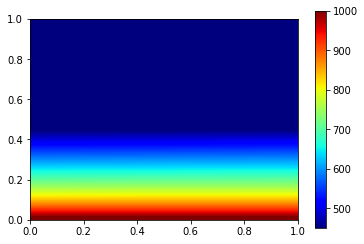

In [9]:
fig, ax = plt.subplots(1,1)
cmap = plt.cm.jet

img3 = ax.imshow(np.flipud(u_pred_3d[:,:,50]),vmax =1000,vmin=450,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)
fig.colorbar(img3, orientation='vertical')

In [16]:
import subprocess
import os

In [20]:
def generate_video():
    for i in range(100):
        #plt.imshow(img[i], cmap=cm.Greys_r)
        img3 = ax.imshow(np.flipud(u_pred_3d[:,:,i]),vmax =1000,vmin=450,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)
        
        plt.savefig("stan_heat_%02d.png" % i)

    #os.chdir()
    subprocess.call(['ffmpeg', '-framerate', '8', '-i', 'stan_heat_%02d.png', '-r', '10', '-pix_fmt', 'yuv420p','Stan_transient.mp4'])
    for file_name in glob.glob("*.png"):
        os.remove(file_name)

In [21]:
generate_video()

FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg': 'ffmpeg'

<Figure size 432x288 with 0 Axes>

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


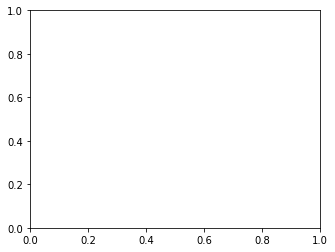

In [33]:
import matplotlib.animation as animation

fig, ax = plt.subplots(1,1)
# img = [] # some array of images
frames = [] # for storing the generated images
# fig = plt.figure()
for i in range(100):
#     p1 = ax.imshow(np.flipud(u_pred_3d[:,:,i]),vmax =1000,vmin=450,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)
#     fig.colorbar(p1, orientation='vertical',ax=ax)
    frames.append([plt.imshow(np.flipud(u_pred_3d[:,:,i]),vmax =1000,vmin=450,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)])
    print(i)

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
#ani.save('movie.mp4')
plt.show()

In [27]:
writergif = animation.PillowWriter(fps=10)
ani.save('Stan_Thinplate_movie.gif',writer=writergif)

In [35]:
writervideo = animation.FFMpegWriter(fps=60) 
ani.save('Stan_Thinplate_movie1.gif',writer=writervideo)

FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg': 'ffmpeg'

In [ ]:
np.max(u_pred_3d[:,:,50])

In [ ]:
plt.plot(u_pred_3d[50,99,:])

In [ ]:
a = 0
for i in range(10):
    a = a + test_loss_full[i][-1]
print(a/10)

In [ ]:
a = 0
for i in range(10):
    a = a + train_loss_full[i][-1]
print(a/10)